In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# convert str to datatime
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = '/kaggle/input/battery-health-nasa-dataset-new/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...


<ipython-input-2-b67dd9e7c5dc>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


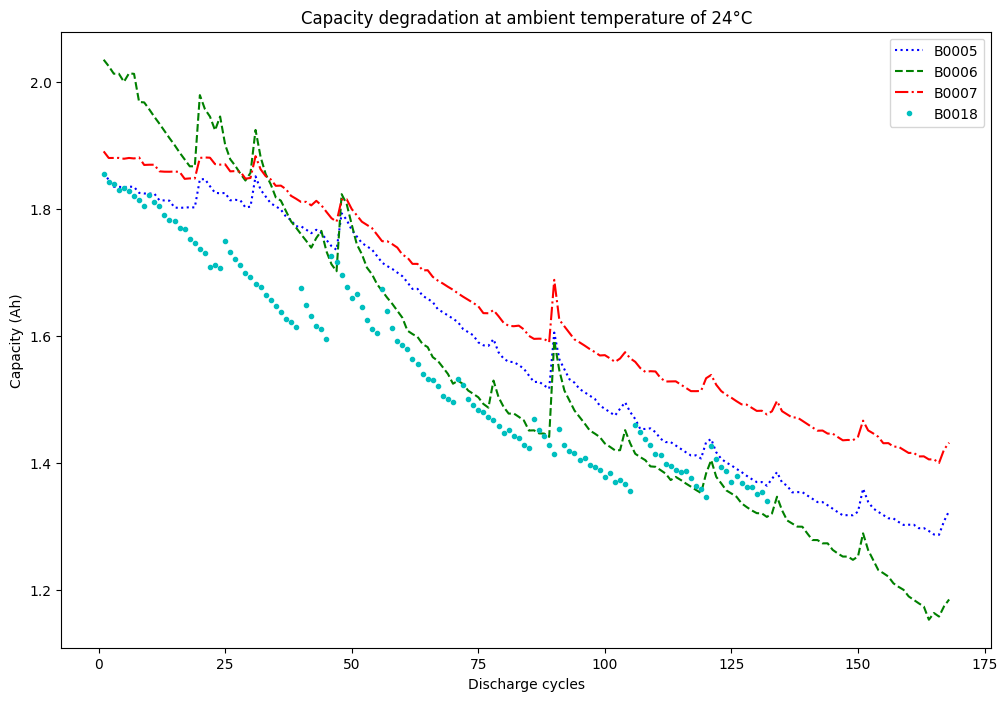

In [4]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [5]:
def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]

    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v[1], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0

    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break

    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break

    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1

    return score

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional Encoding (Optional but often helpful)
class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, feature_len, feature_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


# Series Decomposition (Trend + Seasonal)
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        trend = self.moving_avg(x.transpose(1, 2)).transpose(1, 2)
        seasonal = x - trend
        return seasonal, trend


# Auto-Correlation Layer (simplified)
class AutoCorrelationLayer(nn.Module):
    def __init__(self, d_model):
        super(AutoCorrelationLayer, self).__init__()
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.output_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        Q = self.query_proj(x)
        K = self.key_proj(x)
        V = self.value_proj(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.size(-1))
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)
        return self.output_proj(context)


# Autoformer Encoder Layer
class AutoformerEncoderLayer(nn.Module):
    def __init__(self, d_model, kernel_size=3):
        super(AutoformerEncoderLayer, self).__init__()
        self.decomp = SeriesDecomposition(kernel_size)
        self.auto_corr = AutoCorrelationLayer(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, x):
        seasonal, trend = self.decomp(x)
        seasonal = self.auto_corr(seasonal)
        seasonal = self.ff(seasonal)
        return seasonal + trend


# Full Autoformer Model
class AutoformerNet(nn.Module):
    def __init__(self, feature_size=1, seq_len=16, d_model=256, num_layers=2, kernel_size=3):
        super(AutoformerNet, self).__init__()
        self.input_proj = nn.Linear(feature_size, d_model)
        self.pos_encoding = PositionalEncoding(feature_len=seq_len, feature_size=d_model)
        self.encoder_layers = nn.ModuleList([
            AutoformerEncoderLayer(d_model=d_model, kernel_size=kernel_size)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_len, feature_size)
        x = self.input_proj(x)                      # -> (batch, seq_len, d_model)
        x = self.pos_encoding(x)                    # Add positional info

        for layer in self.encoder_layers:
            x = layer(x)                            # Pass through encoder layers

        out = x.mean(dim=1)                         # Global average pooling
        out = self.output_layer(out)                # Final prediction
        return out

In [7]:
import torch
import torch.nn.functional as F
import numpy as np

def compute_metrics(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    re = np.mean(np.abs((y_pred - y_true) / y_true))
    return rmse, re

def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=50):
    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch}/{epochs}] - Loss: {avg_loss:.6f}")

        # Every 10 epochs, evaluate on validation set
        if epoch % 10 == 0:
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device).float()
                    y_val = y_val.to(device).float()

                    pred = model(x_val)
                    all_preds.append(pred)
                    all_labels.append(y_val)

            y_pred = torch.cat(all_preds, dim=0)
            y_true = torch.cat(all_labels, dim=0)

            rmse, re = compute_metrics(y_pred, y_true)
            print(f"Validation RMSE: {rmse:.6f}, RE: {re:.6f}")

In [8]:
def create_sliding_window_data(Battery, window_size=16):
    X_all, Y_all = [], []

    for battery_id, (cycles, capacities) in Battery.items():
        capacities = torch.tensor(capacities).float()
        n = len(capacities)
        
        for i in range(n - window_size):
            x = capacities[i:i + window_size]
            y = capacities[i + window_size]  # next value
            X_all.append(x.unsqueeze(-1))  # (16,) -> (16, 1)
            Y_all.append(y.unsqueeze(0))   # ()   -> (1,)

    X_all = torch.stack(X_all)  # (num_samples, 16, 1)
    Y_all = torch.stack(Y_all)  # (num_samples, 1)
    return X_all, Y_all

In [9]:
X, Y = create_sliding_window_data(Battery, window_size=16)

print(X.shape)  # Expected: (total_windows, 16, 1)
print(Y.shape)  # Expected: (total_windows, 1)

torch.Size([572, 16, 1])
torch.Size([572, 1])


In [10]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X, Y)

# Optional: Split into train/val/test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim


# === 2. Sliding window conversion ===
def create_sliding_window_data(Battery, window_size=16):
    X_all, Y_all = [], []
    for battery_id, (cycles, capacities) in Battery.items():
        capacities = torch.tensor(capacities).float()
        for i in range(len(capacities) - window_size):
            x = capacities[i:i + window_size]
            y = capacities[i + window_size]
            X_all.append(x.unsqueeze(-1))  # (16, 1)
            Y_all.append(y.unsqueeze(0))   # (1,)
    return torch.stack(X_all), torch.stack(Y_all)

X, Y = create_sliding_window_data(Battery, window_size=16)

# === 3. Create DataLoaders ===
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [12]:
import torch
import numpy as np

def compute_metrics(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()

    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    re = np.mean(np.abs((y_pred - y_true) / y_true))
    return rmse, re

def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=50):
    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device).float()  # Shape: (batch, seq_len, 1)
            y_batch = y_batch.to(device).float()  # Shape: (batch, 1)

            optimizer.zero_grad()
            output = model(x_batch)              # Shape: (batch, 1)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch}/{epochs}] - Loss: {avg_loss:.6f}")

        # Every 10 epochs, evaluate metrics
        if epoch % 10 == 0:
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device).float()
                    y_val = y_val.to(device).float()

                    preds = model(x_val)
                    all_preds.append(preds)
                    all_labels.append(y_val)

            y_pred = torch.cat(all_preds, dim=0)
            y_true = torch.cat(all_labels, dim=0)

            rmse, re = compute_metrics(y_pred, y_true)
            print(f"Validation RMSE: {rmse:.6f}, RE: {re:.6f}")


In [13]:
model = AutoformerNet(feature_size=1, seq_len=16, d_model=256, num_layers=2, kernel_size=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model, train_loader, val_loader, optimizer, criterion, device, epochs=50)

Epoch [1/50] - Loss: 0.235090
Epoch [2/50] - Loss: 0.003118
Epoch [3/50] - Loss: 0.001094
Epoch [4/50] - Loss: 0.000885
Epoch [5/50] - Loss: 0.000821
Epoch [6/50] - Loss: 0.000772
Epoch [7/50] - Loss: 0.000815
Epoch [8/50] - Loss: 0.000823
Epoch [9/50] - Loss: 0.000780
Epoch [10/50] - Loss: 0.000785
Validation RMSE: 0.032223, RE: 0.013454
Epoch [11/50] - Loss: 0.000793
Epoch [12/50] - Loss: 0.000814
Epoch [13/50] - Loss: 0.000818
Epoch [14/50] - Loss: 0.000823
Epoch [15/50] - Loss: 0.000887
Epoch [16/50] - Loss: 0.000977
Epoch [17/50] - Loss: 0.000773
Epoch [18/50] - Loss: 0.000850
Epoch [19/50] - Loss: 0.000962
Epoch [20/50] - Loss: 0.000885
Validation RMSE: 0.033294, RE: 0.013766
Epoch [21/50] - Loss: 0.000783
Epoch [22/50] - Loss: 0.000962
Epoch [23/50] - Loss: 0.000793
Epoch [24/50] - Loss: 0.000810
Epoch [25/50] - Loss: 0.000961
Epoch [26/50] - Loss: 0.000937
Epoch [27/50] - Loss: 0.000879
Epoch [28/50] - Loss: 0.000853
Epoch [29/50] - Loss: 0.000823
Epoch [30/50] - Loss: 0.000795

In [14]:
def predict_sliding_window(model, Battery, window_size=16, device='cpu'):
    model.eval()
    predictions = {}

    with torch.no_grad():
        for key, (cycles, capacities) in Battery.items():
            capacities_tensor = torch.tensor(capacities, dtype=torch.float32)
            preds = []

            for i in range(len(capacities_tensor) - window_size):
                input_seq = capacities_tensor[i:i + window_size].unsqueeze(1).unsqueeze(0)  # (1, 16, 1)
                input_seq = input_seq.to(device)

                pred = model(input_seq)  # (1, 1)
                preds.append(pred.item())

            predictions[key] = preds

    return predictions


In [15]:
def predict_recursive(model, Battery, window_size=16, pred_steps=50, device='cpu'):
    model.eval()
    recursive_preds = {}

    with torch.no_grad():
        for key, (cycles, capacities) in Battery.items():
            capacities_tensor = torch.tensor(capacities, dtype=torch.float32)
            input_seq = capacities_tensor[:window_size].clone()  # start with first window
            sequence = input_seq.tolist()

            for _ in range(pred_steps):
                x_input = input_seq[-window_size:].unsqueeze(1).unsqueeze(0).to(device)  # (1, 16, 1)
                pred = model(x_input)
                pred_value = pred.item()
                sequence.append(pred_value)
                input_seq = torch.cat([input_seq, torch.tensor([pred_value])])

            recursive_preds[key] = sequence  # input + pred_steps

    return recursive_preds


In [16]:
# Assuming model is trained and on correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Sliding window prediction
sliding_preds = predict_sliding_window(model, Battery, window_size=16, device=device)

# Recursive (auto-regressive) prediction for 50 steps beyond initial 16
recursive_preds = predict_recursive(model, Battery, window_size=16, pred_steps=117, device=device)

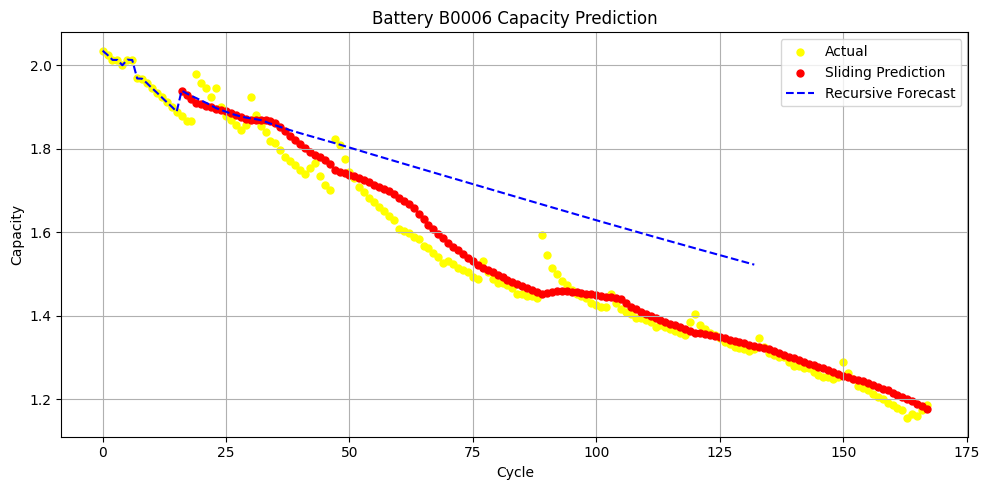

In [17]:
import matplotlib.pyplot as plt

batt_id = 'B0006'

actual_capacities = Battery[batt_id][1]
sliding_range = range(16, 16 + len(sliding_preds[batt_id]))
recursive_range = range(len(recursive_preds[batt_id]))

plt.figure(figsize=(10, 5))

# Actual as yellow scatter
plt.scatter(range(len(actual_capacities)), actual_capacities, label='Actual', color='yellow', s=25)

# Sliding window prediction as red scatter
plt.scatter(sliding_range, sliding_preds[batt_id], label='Sliding Prediction', color='red', s=25)

# Recursive forecast as dashed line
plt.plot(recursive_range, recursive_preds[batt_id], label='Recursive Forecast', linestyle='--', color='blue')

plt.legend()
plt.title(f"Battery {batt_id} Capacity Prediction")
plt.xlabel("Cycle")
plt.ylabel("Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()


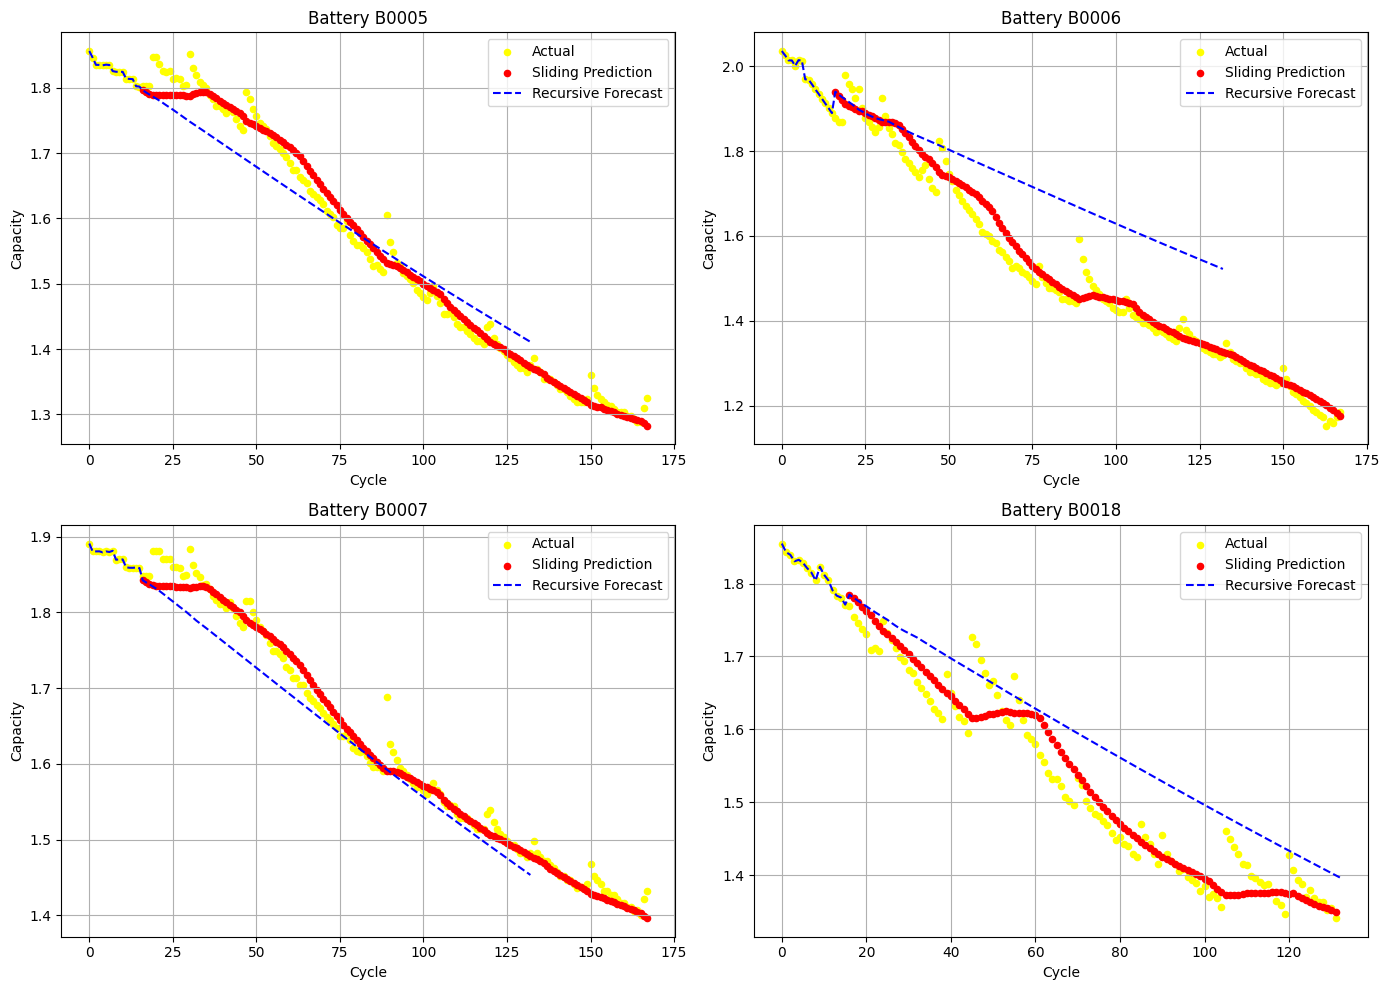

In [18]:
import matplotlib.pyplot as plt

battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, batt_id in enumerate(battery_ids):
    ax = axs[idx]
    
    actual_capacities = Battery[batt_id][1]
    sliding_range = range(16, 16 + len(sliding_preds[batt_id]))
    recursive_range = range(len(recursive_preds[batt_id]))

    # Plot actual
    ax.scatter(range(len(actual_capacities)), actual_capacities, color='yellow', label='Actual', s=20)

    # Plot sliding window prediction
    ax.scatter(sliding_range, sliding_preds[batt_id], color='red', label='Sliding Prediction', s=20)

    # Plot recursive forecast
    ax.plot(recursive_range, recursive_preds[batt_id], linestyle='--', color='blue', label='Recursive Forecast')

    ax.set_title(f'Battery {batt_id}')
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Capacity")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [19]:
torch.save(model.state_dict(), 'AutoReformer.pth')